## Import Libs

In [1]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data
import pickle5

# import sklearn models and functions
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import xgboost as xgb


# import shap for interpretation
import shap # v0.39.0
shap.initjs()

# for queries
from sqlalchemy import create_engine
from MyCreds.mycreds import Capstone_AWS_RO       #from local site-packages

## Get data from Server and Process

In [2]:
# get data with location features - shorter time frame (15 years - 441k data points)
train_df_dl,validate_df_dl,test_df_dl = get_data.get_data('resale_location_features',2007,2015,2016,2018,2019)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done


In [3]:
# preprocess data - note we drop flat_model as most don't know the flat_model and overlaps with flat_type making it hard to use as a feature
one_hot_encode = ['town','flat_type']

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

## Get Train Test Validate Splits

In [4]:
# create train_test_splits

columns_to_drop = ['resale_price_norm',
                'price_per_sq_ft_norm',
                'price_per_sq_m_norm',
                'price_per_sq_ft_per_lease_yr_norm',
                'price_per_sq_m_per_lease_yr_norm',
                ]
targets = ['price_per_sq_m_per_lease_yr_norm']
features_list = [x for x in train_df.columns.tolist() if x not in columns_to_drop]

X_train = train_df[features_list]
y_train = train_df[targets]
X_test = test_df[features_list]
y_test = test_df[targets]
X_val = validate_df[features_list]
y_val = validate_df[targets]

## Save files - for future use to avoid having to download again

In [6]:
# pickle files
train_df.to_pickle('../stuart/jar2/train_df.pkl')
test_df.to_pickle('../stuart/jar2/test_df.pkl')
validate_df.to_pickle('../stuart/jar2/validate_df.pkl')
X_train.to_pickle('../stuart/jar2/X_train.pkl')
y_train.to_pickle('../stuart/jar2/y_train.pkl')
X_test.to_pickle('../stuart/jar2/X_test.pkl')
y_test.to_pickle('../stuart/jar2/y_test.pkl')
X_val.to_pickle('../stuart/jar2/X_val.pkl')
y_val.to_pickle('../stuart/jar2/y_val.pkl')

## Load files - to reduce time taken to download and process files

In [2]:
# unpickle files
train_df = pd.read_pickle('../stuart/jar2/train_df.pkl')
test_df = pd.read_pickle('../stuart/jar2/test_df.pkl')
validate_df = pd.read_pickle('../stuart/jar2/validate_df.pkl')
X_train = pd.read_pickle('../stuart/jar2/X_train.pkl')
y_train = pd.read_pickle('../stuart/jar2/y_train.pkl')
X_test = pd.read_pickle('../stuart/jar2/X_test.pkl')
y_test = pd.read_pickle('../stuart/jar2/y_test.pkl')
X_val = pd.read_pickle('../stuart/jar2/X_val.pkl')
y_val = pd.read_pickle('../stuart/jar2/y_val.pkl')

## Model and Scoring Function

In [3]:
def run_model(model,param_grid,X_train,y_train,X_val,y_val,X_test,y_test):
    
    if len(param_grid)==0:
        reg = model.fit(X_train, y_train)
    else:
    # run gridsearchCV
        grid_cv = GridSearchCV(model, param_grid, scoring="r2", cv=3,verbose=3).fit(X_train, y_train)
        reg = grid_cv.best_estimator_

        best_score = grid_cv.best_score_
        best_params = grid_cv.best_params_
        print(f'Best Score for CV: {best_score}')
        print(f'Best Parameters: {best_params}')

    # get predicitons
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_val = r2_score(y_val,y_pred_val)
    score_test = r2_score(y_test,y_pred_test)
    
    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_val = mean_squared_error(y_val,y_pred_val)
    mse_test = mean_squared_error(y_test,y_pred_test)

    # print results
    r2_results = f'R2 Scores: \nTrain:{score_train:.3f} \nValidation:{score_val:.3f}\nTest:{score_test:.3f}\nMSE: \nTrain:{mse_train:.3f}\nValidation:{mse_val:.3f} \nTest:{mse_test:.3f}'
    print (r2_results)

    return reg

In [4]:
def run_model_noval(model,param_grid,X_train,y_train,X_val,y_val,X_test,y_test):
    
    #combine test and validation
    X_test = pd.concat([X_test,X_val],ignore_index=False).reset_index(drop=True)
    y_test = pd.concat([y_test,y_val],ignore_index=False).reset_index(drop=True)

    
    if len(param_grid)==0:
        reg = model.fit(X_train, y_train)
    else:
    # run gridsearchCV
        grid_cv = GridSearchCV(model, param_grid, scoring="r2", cv=3,verbose=3).fit(X_train, y_train)
        reg = grid_cv.best_estimator_

        best_score = grid_cv.best_score_
        best_params = grid_cv.best_params_
        print(f'Best Score for CV: {best_score}')
        print(f'Best Parameters: {best_params}')

    # get predicitons
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_test = r2_score(y_test,y_pred_test)
    
    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)

    # print results
    r2_results = f'R2 Scores: \nTrain:{score_train:.3f} \nTest:{score_test:.3f}\nMSE: \nTrain:{mse_train:.3f}\nTest:{mse_test:.3f}'
    print (r2_results)

    return reg

## Optimal settings from MANUAL tuning 

- max_depth = 7
- min_child_weight = 5
- gamma = 14
- subsample = 0.5
- colsample_bytree = 0.5
- reg_alpha = 100
- reg_lambda = 1
- n_estimators = 900
- learning_rate = 0.175

### High level approach to tuning
- Tune max depth and min_child_weight
- Tune gamma
- Tune subsample and colsample_bytree
- Optional tune reg_alpha and reg_lambda for overfitting
- Last reduce learning rate and increase trees


### Scores
#### R2 Scores: 
- Train:0.962 
- Validation:0.897
- Test:0.795
#### MSE: 
- Train:11.153
- Validation:40.907 
- Test:71.863

### Scores - combined validation/test set
#### R2 Scores: 
- Train:0.962 
- Test:0.843
#### MSE: 
- Train:11.153
- Test:58.256

## Train Model for Production

In [5]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    min_child_weight=5,
    gamma = 14,
    subsample=0.5,
    colsample_bytree = 0.5,
    reg_alpha = 100,
    reg_lambda = 1,
    n_estimators=900,
    learning_rate=0.175,
    nthread=4,
    seed=42,
    tree_method='hist'
    )
param_grid = {}

model = run_model(model,param_grid,X_train,y_train,X_val,y_val,X_test,y_test)

R2 Scores: 
Train:0.962 
Validation:0.897
Test:0.795
MSE: 
Train:11.153
Validation:40.907 
Test:71.863


In [6]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    min_child_weight=5,
    gamma = 14,
    subsample=0.5,
    colsample_bytree = 0.5,
    reg_alpha = 100,
    reg_lambda = 1,
    n_estimators=900,
    learning_rate=0.175,
    nthread=4,
    seed=42,
    tree_method='hist'
    )
param_grid = {}

model = run_model_noval(model,param_grid,X_train,y_train,X_val,y_val,X_test,y_test)

R2 Scores: 
Train:0.962 
Test:0.843
MSE: 
Train:11.153
Test:58.256


In [113]:
# save model to file
pickle5.dump(model, open("../stuart/jar2/model_xgb.pickle.dat", "wb"))

## Get Full Model SHAP

In [7]:
X_shap = pd.concat([X_train,X_test,X_val],ignore_index=False).reset_index(drop=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_shap)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


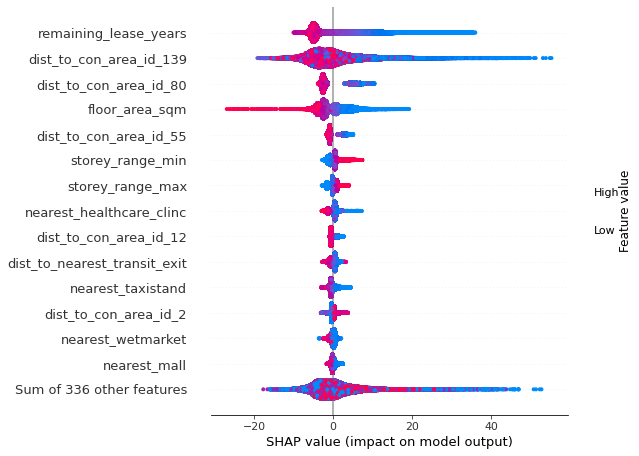

In [18]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values,max_display=15)

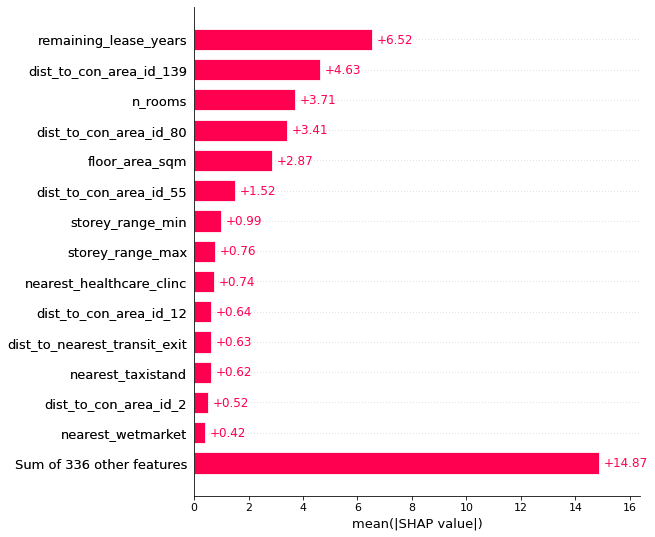

In [19]:
shap.plots.bar(shap_values,max_display=15)